In [ ]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

In [ ]:
seed = 2724

### Import data

In [ ]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [ ]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [ ]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

### Use SHAP to explain the model on test data

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

This will allow us to see which variables are most important to predicting the outcome.

In [ ]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [16]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [15]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.086254,-0.170779,5.866534
1,1.020094,-0.192841,-6.859435


### Let's put `group` and `zipcode_score` in the same plot

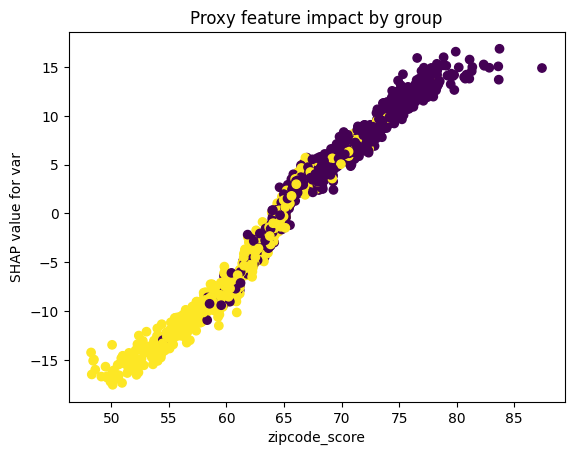

In [14]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

A shapley value is a method used to explain the output of a ML model. It measures the difference between the actual and average predictions and distributes that difference among the input features.

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

No, I didn't. Group was excluded from the training phase completely.

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Yes, while i didnt use group directly, the pynb uses it to calculate the mean of shap values grouped by group.

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

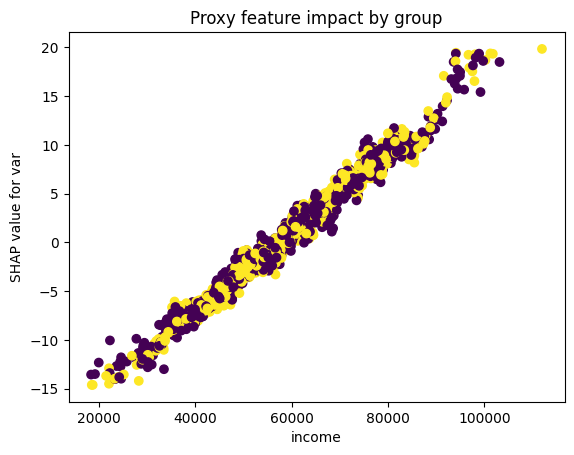

In [13]:
plot_shap("income")

The income plot shows the colors mixed together, showing that income is more fair since it doesnt vary much by group. The zipcode score has colors separated, showing a bias.

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

I would ask if it would be more fair and remove the bias is zipcode_score was removed completely. I would also ask how the zipcode_score was calculated, if it was from historical data that already contains human bias itself.